# QOSF screening challenge
https://www.qosf.org/

2020-09-10

by [Kunal Marwaha](https://kunalmarwaha.com/about)

## Getting started

This is my first time using qiskit, but I'll give it a go.

I know how to turn $|00\rangle$ into an equal combination of $|01\rangle$ and $|10\rangle$, but it uses a Hadamard gate.

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
qc_with_h = QuantumCircuit(2)
qc_with_h.x(0)
qc_with_h.x(1)
qc_with_h.h(0)
qc_with_h.cx(0, 1)
qc_with_h.draw()

┌───┐┌───┐     
q_0: ┤ X ├┤ H ├──■──
     ├───┤└───┘┌─┴─┐
q_1: ┤ X ├─────┤ X ├
     └───┘     └───┘

/home/kunal/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


Text(0.5, 1.0, 'Probability weights in state vector')

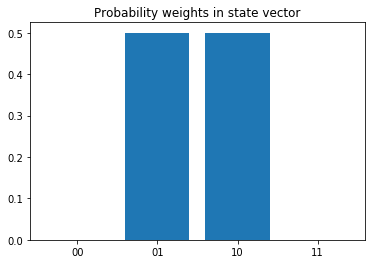

In [3]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc_with_h,backend).result().get_statevector()
plt.bar(['00', '01', '10', '11'], final_state.conj()*final_state)
plt.title("Probability weights in state vector")

I can show this with qiskit's sampling tools.

In [4]:
qc_with_h_measured = QuantumCircuit(2, 2)
qc_with_h_measured.x(0)
qc_with_h_measured.x(1)
qc_with_h_measured.h(0)
qc_with_h_measured.cx(0, 1)
qc_with_h_measured.measure([0, 1], [0, 1])
qc_with_h_measured.draw()

┌───┐┌───┐     ┌─┐   
q_0: ┤ X ├┤ H ├──■──┤M├───
     ├───┤└───┘┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├─────┤ X ├─╫─┤M├
     └───┘     └───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1

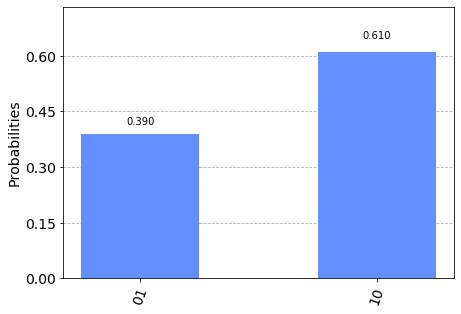

In [5]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc_with_h_measured, backend, shots=100).result().get_counts()
plot_histogram(counts)

This is sampling between two values with 50% chance each. This is like a scaled binomial distribution (with mean $1/2$ and standard deviation $1/(2\sqrt{N})$. By Chebyshev's inequality, the chance of three standard deviations above mean is at most 1/9 (and even smaller if I consider the distribution approximately normal). With good probability I expect the two values to be within $3/(\sqrt{N})$ of each other. For example, with $N=100$, I only expect values within $0.35-0.65$.

## Avoiding the Hadamard

One way I can remove the Hadamard is by inserting $R_x$ and $R_y$ gates in its place. Since the spirit of the problem seems to be "optimize for these parameters", I will insert an $R_y$ and $R_x$ in place of the Hadamard. (I also replace the $X$ gates for $R_x$ gates.)  Then I allow all gates except CNOT to take any parameter.

In [6]:
import numpy as np
from numpy import pi

In [7]:
def gen_circuit(thetas):
    qc = QuantumCircuit(2, 2)
    qc.rx(thetas[0], 0)
    qc.rx(thetas[1], 1)
    qc.ry(thetas[2], 0)
    qc.rx(thetas[3], 0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    return qc

Here's a random example.

In [8]:
rands = np.random.random(4)*2*pi
qc_rand = gen_circuit(rands)
qc_rand.draw()

┌────────────┐┌────────────┐┌────────────┐     ┌─┐   
q_0: ┤ RX(2.4479) ├┤ RY(1.7707) ├┤ RX(3.2658) ├──■──┤M├───
     ├────────────┤└────────────┘└────────────┘┌─┴─┐└╥┘┌─┐
q_1: ┤ RX(3.8473) ├────────────────────────────┤ X ├─╫─┤M├
     └────────────┘                            └───┘ ║ └╥┘
c: 2/════════════════════════════════════════════════╩══╩═
                                                     0  1

In [9]:
def get_counts(qc, shots):
    backend = BasicAer.get_backend('qasm_simulator')
    return execute(qc, backend, shots=shots).result().get_counts()

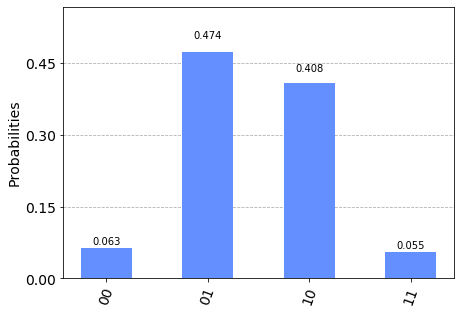

In [10]:
shots = 1000
counts = get_counts(qc_rand, shots)
plot_histogram(counts)

## Optimizing over parameters

I define a loss function by seeing how much the probabilities differ from expected (50% each for $|01\rangle$ and $|10\rangle$):

$$
L = (prob_10 - 0.5)^2 + (prob_01 - 0.5)^2
$$

In [11]:
def loss_from_counts(counts, shots):
    prob_01 = counts.get('01', 0)/shots
    prob_10 = counts.get('10', 0)/shots
    return (prob_10 - 0.5)**2 + (prob_01 - 0.5)**2

In [12]:
loss_from_counts(counts, shots)

0.009140000000000006

Now I try to find the best parameters!

In [13]:
def input_to_loss(inputs, shots):
    qc = gen_circuit(inputs)
    counts = get_counts(qc, shots)
    return loss_from_counts(counts, shots)

In [14]:
from scipy.optimize import minimize

In [15]:
shots = 1000
res = minimize(input_to_loss, np.random.rand(4)*2*pi, method='Powell', args=(shots,))
res

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.08315777,  0.09256503, -0.00465645, -0.00135926]])
     fun: array(0.0017)
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 2
  status: 0
 success: True
       x: array([2.59751634, 2.99042514, 4.76234905, 3.09845965])

In [16]:
print("Best input:", res.x)
print("Loss:", input_to_loss(res.x, shots))

Best input: [2.59751634 2.99042514 4.76234905 3.09845965]
Loss: 0.0016999999999999995


This result is not bad. I plot the circuit probabilities when measuring 1, 10, 100, 1000 times.

In [17]:
qc = gen_circuit(res.x)

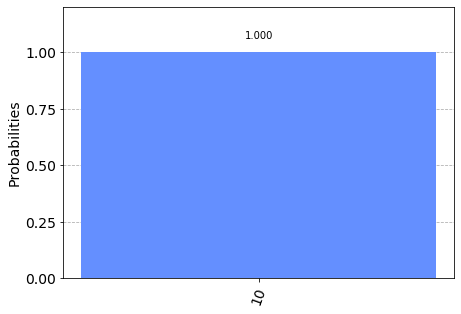

In [18]:
counts = get_counts(qc, 1)
plot_histogram(counts)

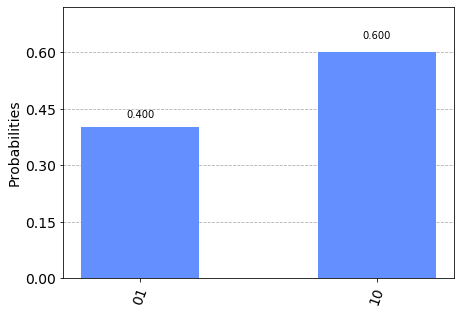

In [19]:
counts = get_counts(qc, 10)
plot_histogram(counts)

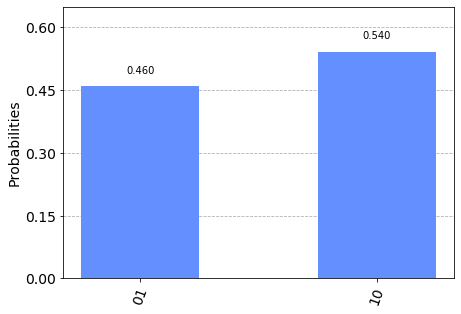

In [20]:
counts = get_counts(qc, 100)
plot_histogram(counts)

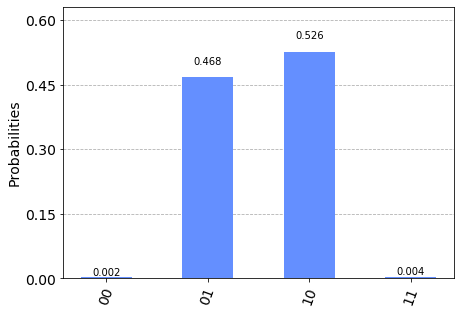

In [21]:
counts = get_counts(qc, 1000)
plot_histogram(counts)

## Analysis

Because I initialize from random inputs, the final circuit seems to change on each run. This probably means I have a whole class of solutions. I could probably re-run this with fewer parameters and find a simpler result.

I'm not discouraged by the plots for very few number of measurements. I expect the distributions to vary widely (at least between $|01\rangle$ and $|10\rangle$).

In [22]:
print("There were this many evaluations:", res.nfev)
print("That corresponds to this many total experiments:", res.nfev*shots)

There were this many evaluations: 168
That corresponds to this many total experiments: 168000


I worked out analytically that a simple $[\pi, \pi, \pi/2, 0]$ should work just fine, since $\sqrt{Y}$ behaves close to a Hadamard.
But there may be other inputs that are also optimal.

The optimization algorithm will work much better with higher amounts of measurements per iteration, because the loss will be noisy (on the order of $0.5/\sqrt{N}$ as discussed before. For example, even the optimal result has a nonzero loss.

In [23]:
input_to_loss([pi, pi, pi/2, 0], shots)

0.0013520000000000025

## Bonus

To produce $|01\rangle + |10\rangle$ instead of $|01\rangle - |10\rangle$, I could also penalize the phase difference. But I don't have access to a state vector. I could instead measure in the Bell basis and optimize for $|\Psi^+\rangle \propto |01\rangle + |10\rangle$.

If I don't have access to a Bell basis, I could apply a $CNOT$ then  $R_y(\pi/2)\otimes I$ to look for the result in the standard basis (at $|01\rangle$). I penalize any probability weight that is not in $|01\rangle$.

In [24]:
def gen_bonus_circuit(thetas):
    qc = QuantumCircuit(2, 2)
    qc.rx(thetas[0], 0)
    qc.rx(thetas[1], 1)
    qc.ry(thetas[2], 0)
    qc.rx(thetas[3], 0)
    # the CNOTs cancel each other!
#     qc.cx(0, 1)
#     qc.cx(0, 1) 
    qc.ry(pi/2, 0)
    qc.measure([0, 1], [0, 1])
    return qc

Here's an example.

In [25]:
c = gen_bonus_circuit([pi, pi, pi/2, 0])

In [26]:
c.draw()

┌────────┐┌──────────┐┌───────┐┌──────────┐┌─┐
q_0: ┤ RX(pi) ├┤ RY(pi/2) ├┤ RX(0) ├┤ RY(pi/2) ├┤M├
     ├────────┤└───┬─┬────┘└───────┘└──────────┘└╥┘
q_1: ┤ RX(pi) ├────┤M├───────────────────────────╫─
     └────────┘    └╥┘                           ║ 
c: 2/═══════════════╩════════════════════════════╩═
                    1                            0

In [27]:
get_counts(c, 100)

{'10': 100}

Notice that the "optimal" result from before does produce the state we are looking for!

In [28]:
def input_to_bonus_loss(inputs, shots):
    qc = gen_bonus_circuit(inputs)
    counts = get_counts(qc, shots)
    # something I learned: qiskit orders its qubits upside-down from the picture!
    return 1 - counts.get('10', 0)/shots

In [29]:
input_to_bonus_loss([pi, pi, pi/2, 0], 100)

0.0

But we can "simulate" this process:

In [30]:
shots = 1000
res = minimize(input_to_bonus_loss, np.random.rand(4)*2*pi, method='Powell', args=(shots,))
res

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 1.50640275e-04,  1.78873203e-05, -1.05366640e-05,
         1.00562098e-03]])
     fun: array(0.)
 message: 'Optimization terminated successfully.'
    nfev: 193
     nit: 3
  status: 0
 success: True
       x: array([ 3.09980025,  3.13055976,  1.57828926, 13.3309928 ])

In [31]:
print("Best input:", res.x)
print("Loss:", input_to_loss(res.x, shots))

Best input: [ 3.09980025  3.13055976  1.57828926 13.3309928 ]
Loss: 0.0023120000000000003


Let's confirm this still gives us equal probability in $|01\rangle$ and $|10\rangle$.

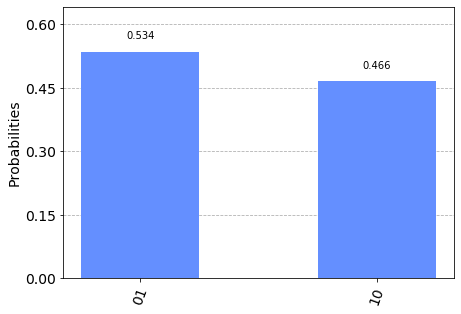

In [32]:
qc = gen_circuit(res.x)
counts = get_counts(qc, 1000)
plot_histogram(counts)

## And that's a wrap!

Thanks for reading. This was an interesting project for me! I enjoyed trying out a quantum circuit library, and I am thankful for all of it being open-source.